In [1]:
# --- 1. Importy ---
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay,
    f1_score
)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 5)


In [2]:
# --- 2. Wczytanie danych -----------------
X_train = pd.read_csv("X_train_woe.csv")
X_test  = pd.read_csv("X_test_woe.csv")

y_train = pd.read_csv("y_train.csv").squeeze()
y_test  = pd.read_csv("y_test.csv").squeeze()

print("Shapes  →  X_train:", X_train.shape, "  X_test:", X_test.shape)
print("Target balance (train):")
print(y_train.value_counts(normalize=True).rename("share").to_frame())


Shapes  →  X_train: (91844, 21)   X_test: (22961, 21)
Target balance (train):
              share
Defaulted          
0          0.852141
1          0.147859


In [3]:
# --- 3. Model bazowy ----------------------
log_reg = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    class_weight="balanced"
)
log_reg.fit(X_train, y_train)
print("Model fitted.")


Model fitted.


              precision    recall  f1-score   support

           0     0.9452    0.7301    0.8238     19553
           1     0.3284    0.7570    0.4581      3408

    accuracy                         0.7341     22961
   macro avg     0.6368    0.7436    0.6410     22961
weighted avg     0.8536    0.7341    0.7696     22961

ROC-AUC: 0.8274


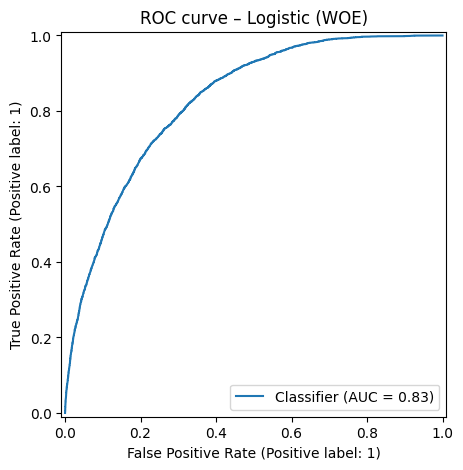

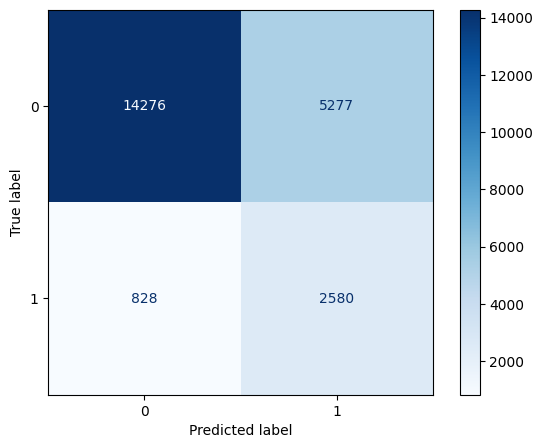

In [4]:
# --- 4. Predykcje i metryki ---------------
y_pred  = log_reg.predict(X_test)
y_prob  = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob).round(4))

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC curve – Logistic (WOE)")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.show()


Najlepszy próg wg F1-score: 0.60


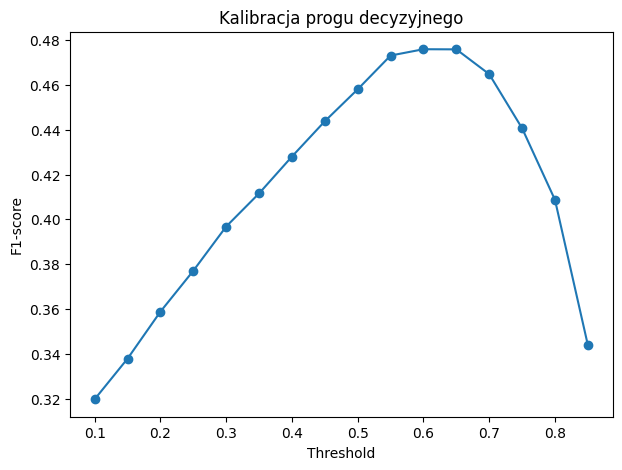

              precision    recall  f1-score   support

           0       0.93      0.82      0.87     19553
           1       0.38      0.63      0.48      3408

    accuracy                           0.79     22961
   macro avg       0.65      0.73      0.67     22961
weighted avg       0.85      0.79      0.81     22961



In [5]:
# --- 5. Kalibracja progu ------------------
thresholds = np.arange(0.1, 0.9, 0.05)
scores = []

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    score = f1_score(y_test, y_pred_thresh)
    scores.append(score)

best_thresh = thresholds[np.argmax(scores)]
print(f"Najlepszy próg wg F1-score: {best_thresh:.2f}")

plt.plot(thresholds, scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('Kalibracja progu decyzyjnego')
plt.show()

y_pred_calibrated = (y_prob >= best_thresh).astype(int)
print(classification_report(y_test, y_pred_calibrated))


Liczba zmiennych z zerowym współczynnikiem: 0


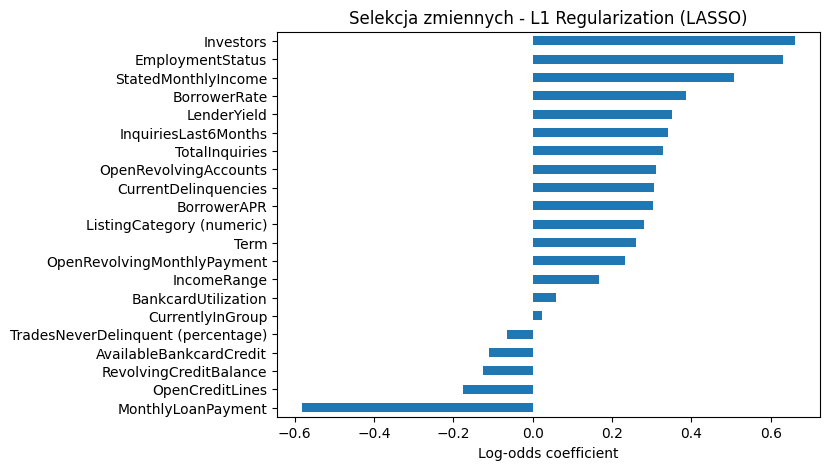

In [6]:
# --- 6. Selekcja zmiennych L1 -------------
log_reg_l1 = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000
)
log_reg_l1.fit(X_train, y_train)

coef = pd.Series(log_reg_l1.coef_[0], index=X_train.columns)
print("Liczba zmiennych z zerowym współczynnikiem:", (coef == 0).sum())

coef[coef != 0].sort_values().plot(kind="barh")
plt.title("Selekcja zmiennych - L1 Regularization (LASSO)")
plt.xlabel("Log-odds coefficient")
plt.show()


In [7]:
# --- 7. Zapis wytrenowanego modelu --------
import joblib, os
os.makedirs("models", exist_ok=True)

joblib.dump(log_reg, "models/logreg_woe.pkl")
print("Model zapisany → models/logreg_woe.pkl")


Model zapisany → models/logreg_woe.pkl


In [10]:
# --- 8. Automatyczny raport podsumowujący ---
print("\n" + "="*30)
print("RAPORT MODELU KREDYTOWEGO")
print("="*30)

# Dane
print("\nLiczność zbiorów danych:")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_test : {X_test.shape} | y_test : {y_test.shape}")

# Default rate
print("\nDefault rate (train vs test):")
print(f"Train: {y_train.mean():.4f} ({y_train.sum()}/{len(y_train)})")
print(f"Test : {y_test.mean():.4f} ({y_test.sum()}/{len(y_test)})")

# Wyniki modelu bazowego
print("\n--- Model bazowy (Logistic Regression) ---")
print("Accuracy na zbiorze testowym:", (y_pred == y_test).mean().round(4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob).round(4))

# Wyniki po kalibracji
print("\n--- Model po kalibracji progu ---")
print(f"Optymalny próg (F1-score) = {best_thresh:.2f}")
y_pred_calibrated = (y_prob >= best_thresh).astype(int)
print("Accuracy:", (y_pred_calibrated == y_test).mean().round(4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob).round(4))
print("F1-score:", round(f1_score(y_test, y_pred_calibrated), 4))

# L1 - liczba wybranych zmiennych
print("\n--- Selekcja zmiennych (L1) ---")
n_selected = (coef != 0).sum()
print(f"Liczba zmiennych wybranych przez L1: {n_selected}/{len(coef)}")





RAPORT MODELU KREDYTOWEGO

Liczność zbiorów danych:
X_train: (91844, 21) | y_train: (91844,)
X_test : (22961, 21) | y_test : (22961,)

Default rate (train vs test):
Train: 0.1479 (13580/91844)
Test : 0.1484 (3408/22961)

--- Model bazowy (Logistic Regression) ---
Accuracy na zbiorze testowym: 0.7341
ROC-AUC: 0.8274

--- Model po kalibracji progu ---
Optymalny próg (F1-score) = 0.60
Accuracy: 0.7932
ROC-AUC: 0.8274
F1-score: 0.4759

--- Selekcja zmiennych (L1) ---
Liczba zmiennych wybranych przez L1: 21/21
